In [394]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from collections import defaultdict
import numba as nb
from skimage.morphology import label
from scipy.ndimage import measurements

speedups.enable()

In [395]:
url='https://www.janestreet.com/puzzles/subtiles//'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:19]))

Place an integer between 1 and 17 into some of the empty cells in the grid. When completed, the grid should have one 1, two 2’s, etc., up to seventeen 17’s. Furthermore, for all N larger than 1, the squares marked N must form a connected N -omino whose shape “contains” the ( N −1)-omino determined by the ( N −1)’s. (Reflections and rotations are allowed.) Some of the cells have already been labeled. The answer to this puzzle is the product of the areas of the empty regions in the completed grid.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/10/20181001_subtiles.png" width="350" >

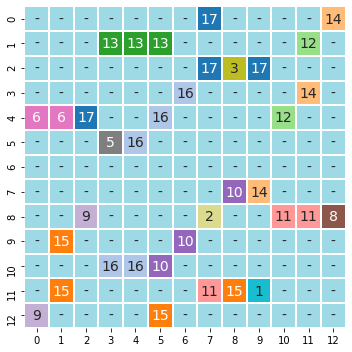

In [407]:
# set up the groups
fixed = np.array([[ 0,  0,  0,  0,  0,  0,  0, 17,  0,  0,  0,  0, 14],
                 [ 0,  0,  0, 13, 13, 13,  0,  0,  0,  0,  0, 12,  0],
                 [ 0,  0,  0,  0,  0,  0,  0, 17,  3, 17,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0, 16,  0,  0,  0,  0, 14,  0],
                 [ 6,  6, 17,  0,  0, 16,  0,  0,  0,  0, 12,  0,  0],
                 [ 0,  0,  0,  5, 16,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0, 10, 14,  0,  0,  0],
                 [ 0,  0,  9,  0,  0,  0,  0,  2,  0,  0, 11, 11,  8],
                 [ 0, 15,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0, 16, 16, 10,  0,  0,  0,  0,  0,  0,  0],
                 [ 0, 15,  0,  0,  0,  0,  0, 11, 15,  1,  0,  0,  0],
                 [ 9,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0]],dtype=int)

def grid_print(grid):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((grid).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(grid,annot=x,cbar=False,cmap="tab20_r",fmt="",linewidths=1,ax=ax,annot_kws={"size":14})

   
    plt.tight_layout()   
    
grid_print(fixed)

In [412]:
class Matrix():
    def __init__(self,fixed):
        self.grid = fixed
        self.grid[3,7] =4
        #set up each grid cell as a polygon for the checking
        omino = np.zeros((25,25),dtype = int)
        omino[12,12] =1
        self.poss_polys=[ [omino,self.grid,2] ]
        self.solved = []

    def move_poly(omino,x,y,rotate,reflect):
        if reflect == 0:
            return np.rot90(omino[x:x+13,y:y+13],rotate)
        if reflect == 1:
            return np.flip(np.rot90(omino[x:x+13,y:y+13],rotate),0)
        
         
    #add blocks to the outside of the polygon
    def poss_new_poly(self,poly):
        new_ominos = []
        for i in range(13):
            for j in range(13):
                if poly[i,j] == 1:
                    continue
                new_omino =dcopy(poly)
                new_omino[i,j] =1
                if np.max(label(new_omino!=0,connectivity=1)) == 1:
                     new_ominos.append(new_omino)
        return new_ominos 
    

    def get_possible_placements(self,poly,grid,next_num):
        poss_polys = []
        for i in range(13):
            for j in range(13):
                for rot in range(4):
                    for ref in range(2):
                        test_grid = move_poly(poly,i,j,rot,ref)
                        if np.sum(test_grid) != next_num:
                            continue
                        if next_num not in grid[test_grid==0]:
                            if np.all([i in (0,next_num) for i in grid[test_grid==1]]):
                                poss_polys.append(test_grid)
        return poss_polys
          
    def areas(self,grid):
        labels, num = measurements.label(grid==0)
        areas = measurements.sum(grid==0, labels, index=range(1, num+1))
        return np.prod(areas)    
        
        
    # main loop to pull it all together
    # find the possible triangles and then send to solve
    # to place
    def solve(self):
        start = time.perf_counter()
        while len(self.poss_polys) >0:
            [poly,grid,next_num] = self.poss_polys.pop()
        
            new_polys = self.poss_new_poly(poly)

            valid_places = []
            for new_poly in new_polys:
                valid_places += self.get_possible_placements(new_poly,grid,next_num) 
                
                unique_places =[]
                for valid_place in valid_places:
                    if any(np.array_equal(valid_place, x) for x in unique_places):
                        continue
                    unique_places.append(valid_place)

                for unique_place in unique_places:
                    new_grid = dcopy(grid)
                    new_grid[unique_place==1] = next_num
                    if next_num <5:
                        self.poss_polys.insert(0,[new_poly,new_grid,next_num+1])
                    else:
                        self.solved.insert(0,new_grid)
        
        print("There are {} solutions".format(len(self.solved)))
        print("The product of areas is {:,.0f}".format(self.areas(self.solved[0])))
        grid_print(self.solved[0])

        end =  time.perf_counter()        
        print("Solution took {:0.6f} seconds".format(end-start))
        
#############################    
# print out the result nicely    


There are 312812 solutions
The product of areas is 3,696
Solution took 472.608391 seconds

Solved Grid
~~~~~~~~~~~


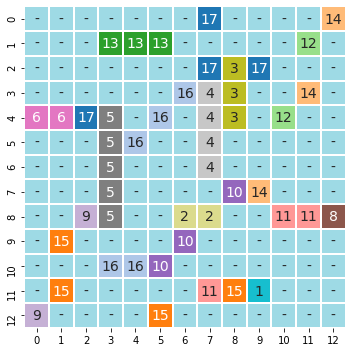

In [413]:
test = Matrix(fixed)
test.solve()
print('\nSolved Grid')
print('~~~~~~~~~~~')

In [369]:
url='https://www.janestreet.com/puzzles/solutions/october-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The unique configuration that satisfies the “sub-tiles” property is shown to the left, and the product of the areas of the empty regions is 256 . Congrats to this month’s solvers!


### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/11/20181031_subtiles_ans.png" width="350" >

counts = [16  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


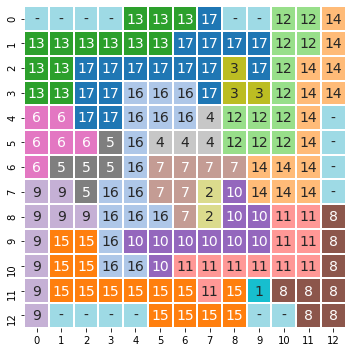

In [194]:
soln = np.array([[ 0,  0,  0,  0, 13, 13, 13, 17,  0,  0, 12, 12, 14],
                 [13, 13, 13, 13, 13, 13, 17, 17, 17, 17, 12, 12, 14],
                 [13, 13, 17, 17, 17, 17, 17, 17,  3, 17, 12, 14, 14],
                 [13, 13, 17, 17, 16, 16, 16, 17,  3,  3, 12, 14, 14],
                 [ 6,  6, 17, 17, 16, 16, 16,  4, 12, 12, 12, 14,  0],
                 [ 6,  6,  6,  5, 16,  4,  4,  4, 12, 12, 12, 14,  0],
                 [ 6,  5,  5,  5, 16,  7,  7,  7,  7, 14, 14, 14,  0],
                 [ 9,  9,  5, 16, 16,  7,  7,  2, 10, 14, 14, 14,  0],
                 [ 9,  9,  9, 16, 16, 16,  7,  2, 10, 10, 11, 11,  8],
                 [ 9, 15, 15, 16, 10, 10, 10, 10, 10, 10, 11, 11,  8],
                 [ 9, 15, 15, 16, 16, 10, 11, 11, 11, 11, 11, 11,  8],
                 [ 9, 15, 15, 15, 15, 15, 15, 11, 15,  1,  8,  8,  8],
                 [ 9,  0,  0,  0,  0, 15, 15, 15, 15,  0,  0,  8,  8]],dtype=int)

grid_print(soln)
print("counts =",np.unique(soln,return_counts=True)[1])
